### 1. Import dependencies

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import time

In [2]:
import torch
from torchvision import datasets, models, transforms

import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import intel_pytorch_extension as ipex

In [3]:
torch.__version__

'1.7.0a0+e85d494'

### 2. Create PyTorch data generators

In [4]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder('data/train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder('data/validation', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=128,
                                shuffle=True, num_workers=0),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=128,
                                shuffle=False, num_workers=0)
}

### 3. Create the network

In [5]:
model = models.resnet50(pretrained=True)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2))


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [11]:
device = torch.device("cpu")
print(device)

cpu


### 4. Train the model

In [12]:
def train_model(model, criterion, optimizer, num_epochs=3, IPEX=False):
    since= time.time()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        #model = model.to(ipex.device)
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                if IPEX:
                    model = model.to(ipex.DEVICE)
                    inputs = inputs.to(ipex.DEVICE)
                    labels = labels.to(ipex.DEVICE)
                else:
                    model =  model.to(device)
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.float() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss.item(),
                                                        epoch_acc.item()))
    time_elapsed = time.time() - since
    train_model.ttime= time_elapsed
    print('Training complete in {:.0f}m {:.0f}s \n \n'.format(time_elapsed // 60, time_elapsed % 60))
    return model

pytorch version: 1.7.0a0+e85d494
ipex version：   1.2.0
Training with normal PyTorch
Epoch 1/3
----------
train loss: 0.6209, acc: 0.6354
validation loss: 0.4194, acc: 0.8150
Epoch 2/3
----------
train loss: 0.3620, acc: 0.8732
validation loss: 0.3050, acc: 0.8900
Epoch 3/3
----------
train loss: 0.3099, acc: 0.8689
validation loss: 0.2513, acc: 0.9100
Training complete in 2m 21s 
 

Training with Intel Extension for PyTorch (IPEX)
Epoch 1/3
----------
train loss: 0.2393, acc: 0.9035
validation loss: 0.3688, acc: 0.8200
Epoch 2/3
----------
train loss: 0.2270, acc: 0.9107
validation loss: 0.2436, acc: 0.9000
Epoch 3/3
----------
train loss: 0.1858, acc: 0.9308
validation loss: 0.2301, acc: 0.9050
Training complete in 1m 25s 
 

Training time (normal): 141.32sec
Training time (ipex):   84.53sec
IPEX achieved 40.19% better performance comparing to normal PyTorch


<BarContainer object of 2 artists>

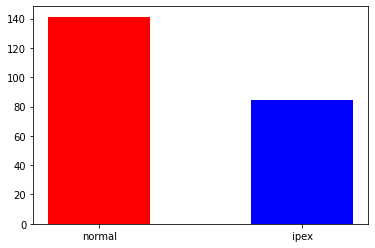

In [13]:
print("pytorch version: {}".format(torch.__version__))
print("ipex version：   {}".format(ipex.__version__))
print("Training with normal PyTorch")
model_trained = train_model(model, criterion, optimizer, num_epochs=3, IPEX=False)
dur_n = train_model.ttime
print("Training with Intel Extension for PyTorch (IPEX)")
model_trained = train_model(model, criterion, optimizer, num_epochs=3, IPEX=True)
dur_i = train_model.ttime
print('Training time (normal): {:.2f}sec'.format(dur_n))
print('Training time (ipex):   {:.2f}sec'.format(dur_i))
print('IPEX achieved {:.2f}% better performance comparing to normal PyTorch'.format((dur_n-dur_i)/dur_n*100.))

plt.bar(["normal", "ipex"], [dur_n, dur_i], width=0.5 , color = ['red' , 'blue'])

In [14]:
def infer_model(model, IPEX=False):
    since= time.time()
    
    model.eval()
                
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders['validation']:
        if IPEX:
            model = model.to(ipex.DEVICE)
            inputs = inputs.to(ipex.DEVICE)
            labels = labels.to(ipex.DEVICE)
        else:
            model =  model.to(device)
            inputs = inputs.to(device)
            labels = labels.to(device)    

        outputs = model(inputs)
        loss = criterion(outputs, labels)


        _, preds = torch.max(outputs, 1)
        running_loss += loss.detach() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(image_datasets['validation'])
    epoch_acc = running_corrects.float() / len(image_datasets['validation'])

    print('validation loss: {:.4f}, acc: {:.4f}'.format(epoch_loss.item(),epoch_acc.item()))
            
    time_elapsed = time.time() - since
    print('Inference complete in {:.0f}m {:.0f}s \n \n'.format(time_elapsed // 60, time_elapsed % 60))
    return time_elapsed

pytorch version: 1.7.0a0+e85d494
ipex version：   1.2.0
Inference with normal PyTorch
validation loss: 0.2301, acc: 0.9050
Inference complete in 0m 13s 
 

Inference with Intel Extension for PyTorch (IPEX)
validation loss: 0.2301, acc: 0.9050
Inference complete in 0m 6s 
 

Inference time (normal): 13.22sec
Inference time (ipex):   5.82sec
IPEX achieved 56.02% better performance comparing to normal PyTorch


<BarContainer object of 2 artists>

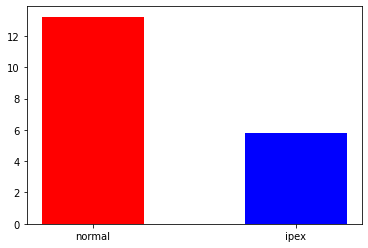

In [15]:
print("pytorch version: {}".format(torch.__version__))
print("ipex version：   {}".format(ipex.__version__))
print("Inference with normal PyTorch")
dur_n = infer_model(model_trained, IPEX=False)
print("Inference with Intel Extension for PyTorch (IPEX)")
dur_i = infer_model(model_trained, IPEX=True)
print('Inference time (normal): {:.2f}sec'.format(dur_n))
print('Inference time (ipex):   {:.2f}sec'.format(dur_i))
print('IPEX achieved {:.2f}% better performance comparing to normal PyTorch'.format((dur_n-dur_i)/dur_n*100.))

plt.bar(["normal", "ipex"], [dur_n, dur_i], width=0.5 , color = ['red' , 'blue'])

### 6. Make predictions on sample test images

In [16]:
validation_img_paths = ["data/validation/alien/11.jpg",
                        "data/validation/alien/22.jpg",
                        "data/validation/predator/33.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [17]:
validation_batch = torch.stack([data_transforms['validation'](img).to(ipex.DEVICE)
                                for img in img_list])

In [18]:
pred_logits_tensor = model_trained(validation_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

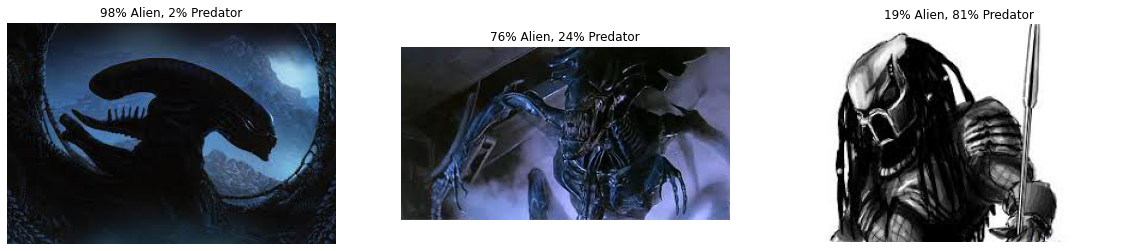

In [19]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                          100*pred_probs[i,1]))
    ax.imshow(img)